# Building custom Einstein Ops functions.

<br>
<br>
<br>
<br>
<br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Union
from functools import lru_cache
import re
import unittest
import time

class EinopsError(Exception):
    """Custom exception for einops-related errors."""
    pass

_token_pattern = re.compile(r'\s*(\.\.\.|[(][^)]*[)]|\S+)\s*')

@lru_cache(maxsize=128)
def tokenize(part: str) -> Tuple[str, ...]:
    tokens = _token_pattern.findall(part.strip())
    print(f"[DEBUG] Tokenized '{part}' into {tokens}")
    return tuple(tokens)

@lru_cache(maxsize=128)
def parse_pattern(pattern: str) -> Tuple[Tuple[str, ...], Tuple[str, ...]]:
    print(f"Parsing pattern: {pattern}")
    if '->' not in pattern:
        raise EinopsError("Pattern must contain '->'")
    input_str, output_str = pattern.split('->')
    print(f"Input string: {input_str}")
    print(f"Output string: {output_str}")
    input_axes = tokenize(input_str)
    output_axes = tokenize(output_str)
    print(f"Input axes: {input_axes}")
    print(f"Output axes: {output_axes}")
    return input_axes, output_axes

def get_axis_sizes(input_axes: Tuple[str, ...], shape: Tuple[int, ...],
                   axes_lengths: Dict[str, int]) -> Dict[str, int]:
    print(f"\nGetting axis sizes for input_axes: {input_axes}")
    print(f"Tensor shape: {shape}")
    print(f"Provided axes_lengths: {axes_lengths}")

    if any(s <= 0 and s != 0 for s in shape):
        raise EinopsError(f"Tensor shape {shape} contains negative dimensions")

    for key, value in axes_lengths.items():
        if not isinstance(value, int) or value <= 0:
            raise EinopsError(f"Invalid axes_lengths: {key}={value} must be a positive integer")

    sizes = {}
    ellipsis_count = input_axes.count('...')
    print(f"Ellipsis count: {ellipsis_count}")
    if ellipsis_count > 1:
        raise EinopsError("Only one ellipsis (...) allowed in pattern")

    shape_len, axes_len = len(shape), len(input_axes)
    if ellipsis_count == 0:
        if shape_len != axes_len:
            raise EinopsError(f"Expected {shape_len} axes, got {axes_len}")
    else:
        explicit_axes = axes_len - 1
        print(f"Ellipsis position: {input_axes.index('...')}, Explicit axes: {explicit_axes}")
        if shape_len < explicit_axes:
            raise EinopsError(f"Too few dimensions: got {shape_len}, need at least {explicit_axes}")

    seen_axes = set()
    for axis in input_axes:
        if axis[0] == '(' and axis[-1] == ')':
            sub_axes = axis[1:-1].split()
            for sub_axis in sub_axes:
                if sub_axis in seen_axes and sub_axis not in axes_lengths:
                    raise EinopsError(f"Axis {sub_axis} appears in multiple groups without explicit size")
                seen_axes.add(sub_axis)
        elif axis != '...':
            if axis in seen_axes and not axis.isdigit():
                raise EinopsError(f"Axis {axis} appears multiple times in input pattern")
            seen_axes.add(axis)

    shape_idx = 0
    for axis in input_axes:
        print(f"Processing axis: {axis} at shape_idx: {shape_idx}")
        if axis == '...':
            ellipsis_dims = shape_len - explicit_axes
            print(f"Expanding ellipsis to {ellipsis_dims} dimensions")
            for i in range(ellipsis_dims):
                key = f'_ellipsis_{i}'
                sizes[key] = shape[shape_idx]
                print(f"Set size['{key}'] = {shape[shape_idx]}")
                shape_idx += 1
        elif axis[0] == '(' and axis[-1] == ')':
            sub_axes = axis[1:-1].split()
            total_size = shape[shape_idx]
            print(f"Group {axis} matches tensor dim {total_size}")
            shape_idx += 1
            provided_size = 1
            provided_count = 0
            for sub_axis in sub_axes:
                if sub_axis in axes_lengths:
                    sizes[sub_axis] = axes_lengths[sub_axis]
                    provided_size *= axes_lengths[sub_axis]
                    provided_count += 1
                    print(f"Set size[{sub_axis}] = {axes_lengths[sub_axis]} from axes_lengths")
                elif sub_axis in sizes:
                    provided_size *= sizes[sub_axis]
                    provided_count += 1
                    print(f"Using existing size[{sub_axis}] = {sizes[sub_axis]}")
            if provided_count == len(sub_axes):
                if provided_size != total_size:
                    raise EinopsError(f"Product of sizes {provided_size} doesn’t match dimension {total_size}")
            elif provided_count < len(sub_axes):
                remaining_size = total_size // provided_size
                remaining_axes = [a for a in sub_axes if a not in sizes]
                if remaining_size * provided_size != total_size:
                    raise EinopsError(f"Cannot evenly divide {total_size} by provided sizes {provided_size}")
                if len(remaining_axes) == 1:
                    sizes[remaining_axes[0]] = remaining_size
                    print(f"Inferred size[{remaining_axes[0]}] = {remaining_size}")
                elif len(remaining_axes) == 0 and provided_size == total_size:
                    print("All sizes match, no inference needed")
                else:
                    raise EinopsError(f"Cannot infer sizes for {remaining_axes} with total {total_size}")
        else:
            key = f'_literal_{shape_idx}' if axis.isdigit() else axis
            if axis.isdigit():
                if int(axis) != shape[shape_idx]:
                    raise EinopsError(f"Expected dimension size {axis}, got {shape[shape_idx]}")
                sizes[key] = int(axis)
                print(f"Set size['{key}'] = {int(axis)} (literal)")
            else:
                sizes[key] = shape[shape_idx]
                # Check consistency with axes_lengths
                if key in axes_lengths and axes_lengths[key] != shape[shape_idx]:
                    raise EinopsError(f"Provided size {key}={axes_lengths[key]} conflicts with tensor shape {shape[shape_idx]}")
                print(f"Set size[{key}] = {shape[shape_idx]}")
            shape_idx += 1
    print(f"Computed axis sizes: {sizes}")
    for key, value in sizes.items():
        if value <= 0 and value != 0:
            raise EinopsError(f"Computed size for {key}={value} is invalid (must be positive)")
    return sizes

def rearrange(tensor: Union[torch.Tensor, np.ndarray], pattern: str, **axes_lengths) -> Union[torch.Tensor, np.ndarray]:
    print(f"\n=== Starting rearrange ===")
    print(f"Input tensor shape: {tensor.shape}")
    print(f"Pattern: {pattern}")
    print(f"Axes lengths: {axes_lengths}")

    is_torch = isinstance(tensor, torch.Tensor)
    if is_torch and not tensor.is_contiguous():
        print("Tensor is non-contiguous, making contiguous")
        tensor = tensor.contiguous()

    input_axes, output_axes = parse_pattern(pattern)
    axis_sizes = get_axis_sizes(input_axes, tensor.shape, axes_lengths)
    print(f"\nAxis sizes: {axis_sizes}")

    print(f"\nStep 1: Preparing intermediate tensor")
    current_tensor = tensor
    axis_map = {}
    shape_idx = 0
    current_shape = list(tensor.shape)
    for axis in input_axes:
        print(f"Mapping axis: {axis} at shape index: {shape_idx}")
        if axis == '...':
            ellipsis_dims = len(tensor.shape) - (len(input_axes) - 1)
            print(f"Ellipsis expands to {ellipsis_dims} dimensions")
            for i in range(ellipsis_dims):
                key = f'_ellipsis_{i}'
                axis_map[key] = shape_idx
                print(f"axis_map['{key}'] = {shape_idx}")
                shape_idx += 1
        elif axis[0] == '(' and axis[-1] == ')':
            sub_axes = axis[1:-1].split()
            new_shape = current_shape[:shape_idx] + [axis_sizes[a] for a in sub_axes] + current_shape[shape_idx + 1:]
            print(f"Reshaping to split group {axis}: {new_shape}")
            current_tensor = current_tensor.view(new_shape) if is_torch else current_tensor.reshape(new_shape)
            for sub_axis in sub_axes:
                axis_map[sub_axis] = shape_idx
                print(f"axis_map[{sub_axis}] = {shape_idx}")
                shape_idx += 1
            current_shape = new_shape
        else:
            key = f'_literal_{shape_idx}' if axis.isdigit() else axis
            axis_map[key] = shape_idx
            print(f"axis_map[{key}] = {shape_idx}")
            shape_idx += 1
    print(f"Current tensor shape after splits: {current_tensor.shape}")
    print(f"Axis map: {axis_map}")

    print(f"\nStep 2: Building transformation steps")
    literal_one_axes = [k for k in axis_map if k.startswith('_literal_') and axis_sizes[k] == 1]
    print(f"Literal '1' axes: {literal_one_axes}")

    individual_output_axes = []
    new_axis_mapping = {}
    new_axis_counter = 0
    for axis in output_axes:
        print(f"Processing output axis: {axis}")
        if axis == '...':
            ellipsis_keys = [k for k in axis_map if k.startswith('_ellipsis_')]
            if ellipsis_keys:
                ellipsis_keys.sort(key=lambda x: int(x.split('_')[-1]))
                individual_output_axes.extend(ellipsis_keys)
                print(f"Ellipsis expanded to: {ellipsis_keys}")
        elif axis[0] == '(' and axis[-1] == ')':
            for sub_axis in axis[1:-1].split():
                if sub_axis in axis_map:
                    individual_output_axes.append(sub_axis)
                    print(f"Group axis: {sub_axis}")
                elif sub_axis in axes_lengths and new_axis_counter < len(literal_one_axes):
                    source_axis = literal_one_axes[new_axis_counter]
                    individual_output_axes.append(source_axis)
                    new_axis_mapping[source_axis] = sub_axis
                    new_axis_counter += 1
                    print(f"New axis {sub_axis} mapped to {source_axis}")
                else:
                    raise EinopsError(f"Unknown axis {sub_axis} or insufficient literal '1' axes")
        elif axis in axis_map:
            individual_output_axes.append(axis)
            print(f"Existing axis: {axis}")
        elif axis in axes_lengths and new_axis_counter < len(literal_one_axes):
            source_axis = literal_one_axes[new_axis_counter]
            individual_output_axes.append(source_axis)
            new_axis_mapping[source_axis] = axis
            new_axis_counter += 1
            print(f"New axis {axis} mapped to {source_axis}")
        elif axis in axes_lengths:
            # New axis without a literal '1', append as a new dimension
            individual_output_axes.append(axis)
            print(f"New axis {axis} added directly")
        else:
            raise EinopsError(f"Unknown axis {axis} in output pattern")
    print(f"Individual output axes: {individual_output_axes}")
    print(f"New axis mapping: {new_axis_mapping}")

    print(f"\nStep 3: Building permutation and expanded shape")
    permutation = tuple(axis_map[axis] for axis in individual_output_axes if axis in axis_map)
    print(f"Permutation: {permutation}")
    expanded_shape = tuple(axes_lengths.get(new_axis_mapping.get(axis, axis), axis_sizes.get(axis, axes_lengths.get(axis)))
                          for axis in individual_output_axes)
    print(f"Expanded shape: {expanded_shape}")

    print(f"\nStep 4: Building final shape")
    final_shape = []
    used_input_axes = set()
    for axis in output_axes:
        print(f"Building final shape for axis: {axis}")
        if axis == '...':
            ellipsis_keys = [k for k in axis_map if k.startswith('_ellipsis_')]
            if ellipsis_keys:
                ellipsis_keys.sort(key=lambda x: int(x.split('_')[-1]))
                sizes_list = [axis_sizes[k] for k in ellipsis_keys]
                final_shape.extend(sizes_list)
                used_input_axes.update(ellipsis_keys)
                print(f"Ellipsis axes sizes: {sizes_list}")
        elif axis[0] == '(' and axis[-1] == ')':
            size = 1
            for sub_axis in axis[1:-1].split():
                if sub_axis in axis_map:
                    size *= axis_sizes[sub_axis]
                    used_input_axes.add(sub_axis)
                    print(f"Multiplying size by {sub_axis} = {axis_sizes[sub_axis]}")
                elif sub_axis in axes_lengths:
                    size *= axes_lengths[sub_axis]
                    print(f"Multiplying size by {sub_axis} = {axes_lengths[sub_axis]} (from axes_lengths)")
            final_shape.append(size)
            print(f"Group {axis} size: {size}")
        elif axis in axis_map:
            final_shape.append(axis_sizes[axis])
            used_input_axes.add(axis)
            print(f"Existing axis {axis} size: {axis_sizes[axis]}")
        elif axis in axes_lengths:
            final_shape.append(axes_lengths[axis])
            print(f"New axis {axis} size: {axes_lengths[axis]}")
    final_shape = tuple(final_shape)
    print(f"Final shape: {final_shape}")
    print(f"Used input axes: {used_input_axes}")

    if any(s <= 0 and s != 0 for s in final_shape):
        raise EinopsError(f"Final shape {final_shape} contains negative dimensions")

    input_axis_set = {k for k in axis_map if not (k.startswith('_literal_') and axis_sizes[k] == 1)}
    print(f"Required input axes: {input_axis_set}")
    if used_input_axes != input_axis_set:
        missing = input_axis_set - used_input_axes
        if missing:
            raise EinopsError(f"Input axes {missing} not present in output pattern.")

    print(f"\nStep 5: Applying transformations")
    if permutation:
        print(f"Transposing with permutation: {permutation}")
        current_tensor = (current_tensor.permute(*permutation) if is_torch else
                          np.transpose(current_tensor, permutation))
        print(f"Shape after transpose: {current_tensor.shape}")

    permuted_shape = current_tensor.shape

    perm_len, exp_len = len(permuted_shape), len(expanded_shape)
    if exp_len > perm_len:
        # Pad permuted_shape
        permuted_shape_padded = (1,) * (exp_len - perm_len) + permuted_shape
    else:
        permuted_shape_padded = permuted_shape[-exp_len:]
    for i, (perm, exp) in enumerate(zip(permuted_shape_padded, expanded_shape)):
        if perm != exp and perm != 1:
            raise EinopsError(f"Broadcasting incompatible: permuted shape {permuted_shape} to expanded {expanded_shape} at dim {i}")

    print(f"Broadcasting to expanded shape: {expanded_shape}")
    current_tensor = (torch.broadcast_to(current_tensor, expanded_shape) if is_torch else
                      np.broadcast_to(current_tensor, expanded_shape))
    print(f"Shape after broadcast: {current_tensor.shape}")

    print(f"Reshaping to final shape: {final_shape}")
    result = (current_tensor.view(final_shape) if is_torch else current_tensor.reshape(final_shape))
    print(f"Final shape: {result.shape}")
    print("=== Rearrange complete ===")
    return result


# Perform Unit Testing and Edge cases

In [2]:
class TestRearrange(unittest.TestCase):
    def test_broadcasting_incompatibility(self):
        print("\n========================================= Testing Broadcasting Incompatibility =============================")
        x = torch.randn(2, 3, 4)
        with self.assertRaises(EinopsError):
            # Force an incompatible broadcast (e.g., changing an existing dim)
            rearrange(x, 'b h w -> b h c', c=5)  # (2, 3, 4) to (2, 3, 5) should fail

    def test_transpose_original(self):
        print("\n============================================== Testing Transpose (Original) =============================")
        x = np.random.rand(3, 4)
        result = rearrange(x, 'h w -> w h')
        np.testing.assert_array_equal(result, x.transpose(1, 0))
        self.assertEqual(result.shape, (4, 3))

    def test_split_axis_original(self):
        print("\n============================================= Testing Split Axis (Original) =============================")
        x = np.random.rand(12, 10)
        result = rearrange(x, '(h w) c -> h w c', h=3)
        self.assertEqual(result.shape, (3, 4, 10))

    def test_merge_axes_original(self):
        print("\n============================================== Testing Merge Axes (Original) =============================")
        x = np.random.rand(3, 4, 5)
        result = rearrange(x, 'a b c -> (a b) c')
        self.assertEqual(result.shape, (12, 5))

    def test_repeat_axis_original(self):
        print("\n============================================= Testing Repeat Axis (Original) =============================")
        x = np.random.rand(3, 1, 5)
        result = rearrange(x, 'a 1 c -> a b c', b=4)
        self.assertEqual(result.shape, (3, 4, 5))
        for i in range(4):
            np.testing.assert_array_equal(result[:, i, :], x[:, 0, :])

    def test_batch_dimensions_original(self):
        print("\n======================================== Testing Batch Dimensions (Original) =============================")
        x = np.random.rand(2, 3, 4, 5)
        result = rearrange(x, '... h w -> ... (h w)')
        self.assertEqual(result.shape, (2, 3, 20))

    def test_errors_original_1(self):
        print("\n=========================================== Testing Error Cases 1 (Original) =============================")
        x = np.random.rand(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> w')

    def test_errors_original_2(self):
        print("\n============================================ Testing Error Cases 2 (Original) =============================")
        x = np.random.rand(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, '(h w) -> h w')

    def test_errors_original_3(self):
        print("\n========================================== Testing Error Cases 3 (Original) =============================")
        x = np.random.rand(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> x y')

    def test_transpose_additional(self):
        print("\n=========================================== Testing Transpose (Additional) =============================")
        x = np.random.rand(3, 4)
        result = rearrange(x, 'h w -> w h')
        np.testing.assert_array_equal(result, x.transpose(1, 0))
        self.assertEqual(result.shape, (4, 3))

    def test_split_axis_additional(self):
        print("\n======================================== Testing Split Axis (Additional) =============================")
        x = np.random.rand(12, 5)
        result = rearrange(x, '(h w) c -> h w c', h=3, w=4)
        self.assertEqual(result.shape, (3, 4, 5))

    def test_merge_axes_additional(self):
        print("\n============================================ Testing Merge Axes (Additional) =============================")
        x = np.random.rand(3, 4, 5)
        result = rearrange(x, 'h w c -> (h w) c')
        self.assertEqual(result.shape, (12, 5))

    def test_repeat_axis_additional(self):
        print("\n========================================= Testing Repeat Axis (Additional) =============================")
        x = np.random.rand(3, 1, 5)
        result = rearrange(x, 'h 1 c -> h b c', b=4)
        self.assertEqual(result.shape, (3, 4, 5))
        for i in range(4):
            np.testing.assert_array_equal(result[:, i, :], x[:, 0, :])

    def test_ellipsis_additional(self):
        print("\n========================================= Testing Ellipsis (Additional) =============================")
        x = np.random.rand(2, 3, 4, 5)
        result = rearrange(x, '... h w -> ... (h w)')
        self.assertEqual(result.shape, (2, 3, 20))

    def test_errors_additional_1(self):
        print("\n========================================= Testing Error Cases 1 (Additional) =============================")
        x = np.random.rand(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> w')

    def test_errors_additional_2(self):
        print("\n========================================= Testing Error Cases 2 (Additional) =============================")
        x = np.random.rand(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, '(h w) -> h w')

    def test_errors_additional_3(self):
        print("\n========================================= Testing Error Cases 3 (Additional) =============================")
        x = np.random.rand(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> x y')

    def test_flatten_all(self):
        print("\n============================================= Testing Flatten All Dimensions =============================")
        x = np.random.rand(4, 8, 2)
        result = rearrange(x, 'h w c -> (h w c)')
        expected_size = 4 * 8 * 2
        self.assertEqual(result.shape, (expected_size,))
        np.testing.assert_array_equal(result, x.reshape(expected_size))

    def test_drop_axis(self):
        print("\n===================================================== Testing Drop Axis =============================")
        x = np.random.rand(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> h')

    def test_neural_net_compatibility(self):
        print("\n========================================= Testing Neural Net Compatibility =============================")
        class SimpleNet(nn.Module):
            def __init__(self):
                super(SimpleNet, self).__init__()
                self.conv = nn.Conv2d(1, 4, kernel_size=3, padding=1)
                self.linear = nn.Linear(4 * 5 * 5, 10)

            def forward(self, x):
                x = self.conv(x)
                x = rearrange(x, 'b c h w -> b (c h w)')
                x = self.linear(x)
                return x

        x = torch.randn(2, 1, 5, 5, requires_grad=True)
        model = SimpleNet()
        output = model(x)
        self.assertEqual(output.shape, (2, 10))
        loss = output.sum()
        loss.backward()
        self.assertIsNotNone(x.grad)
        print(f"Input gradient shape: {x.grad.shape}")

    def test_negative_dimension(self):
        print("\n========================================= Testing Negative Dimension =============================")
        x = torch.randn(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> w h', h=-1)

    def test_non_contiguous_tensor(self):
        print("\n========================================= Testing Non-Contiguous Tensor =============================")
        x = torch.randn(3, 4, 5)
        x = x.transpose(0, 1)  # Non-contiguous, shape becomes (4, 3, 5)
        self.assertFalse(x.is_contiguous())
        result = rearrange(x, 'h w c -> w h c')
        self.assertEqual(result.shape, (3, 4, 5))  # Corrected expectation

    def test_empty_tensor(self):
        print("\n========================================= Testing Empty Tensor =============================")
        x = torch.randn(0, 3, 4)
        result = rearrange(x, 'b h w -> b (h w)')
        self.assertEqual(result.shape, (0, 12))

    def test_invalid_axes_lengths(self):
        print("\n========================================= Testing Invalid Axes Lengths =============================")
        x = torch.randn(3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> w h', h=0)  # Zero length
        with self.assertRaises(EinopsError):
            rearrange(x, 'h w -> w h', h=5)  # Mismatch with shape

    def test_overlapping_grouped_axes(self):
        print("\n========================================= Testing Overlapping Grouped Axes =============================")
        x = torch.randn(12, 5)
        with self.assertRaises(EinopsError):
            rearrange(x, '(h w) (h c) -> h (w c)', h=3)

    def test_broadcasting_incompatibility(self):
        print("\n========================================= Testing Broadcasting Incompatibility =============================")
        x = torch.randn(2, 3, 4)
        with self.assertRaises(EinopsError):
            rearrange(x, 'b h w -> b h w c', c=5)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

................


======================================== Testing Batch Dimensions (Original) =============================

=== Starting rearrange ===
Input tensor shape: (2, 3, 4, 5)
Pattern: ... h w -> ... (h w)
Axes lengths: {}
Parsing pattern: ... h w -> ... (h w)
Input string: ... h w 
Output string:  ... (h w)
[DEBUG] Tokenized '... h w ' into ['...', 'h', 'w']
[DEBUG] Tokenized ' ... (h w)' into ['...', '(h w)']
Input axes: ('...', 'h', 'w')
Output axes: ('...', '(h w)')

Getting axis sizes for input_axes: ('...', 'h', 'w')
Tensor shape: (2, 3, 4, 5)
Provided axes_lengths: {}
Ellipsis count: 1
Ellipsis position: 0, Explicit axes: 2
Processing axis: ... at shape_idx: 0
Expanding ellipsis to 2 dimensions
Set size['_ellipsis_0'] = 2
Set size['_ellipsis_1'] = 3
Processing axis: h at shape_idx: 2
Set size[h] = 4
Processing axis: w at shape_idx: 3
Set size[w] = 5
Computed axis sizes: {'_ellipsis_0': 2, '_ellipsis_1': 3, 'h': 4, 'w': 5}

Axis sizes: {'_ellipsis_0': 2, '_ellipsis_1': 3, 'h': 4, 'w': 5

.........
----------------------------------------------------------------------
Ran 25 tests in 0.245s

OK


Input gradient shape: torch.Size([2, 1, 5, 5])

========================================= Testing Non-Contiguous Tensor =============================

=== Starting rearrange ===
Input tensor shape: torch.Size([4, 3, 5])
Pattern: h w c -> w h c
Axes lengths: {}
Tensor is non-contiguous, making contiguous
Parsing pattern: h w c -> w h c
Input string: h w c 
Output string:  w h c
[DEBUG] Tokenized ' w h c' into ['w', 'h', 'c']
Input axes: ('h', 'w', 'c')
Output axes: ('w', 'h', 'c')

Getting axis sizes for input_axes: ('h', 'w', 'c')
Tensor shape: torch.Size([4, 3, 5])
Provided axes_lengths: {}
Ellipsis count: 0
Processing axis: h at shape_idx: 0
Set size[h] = 4
Processing axis: w at shape_idx: 1
Set size[w] = 3
Processing axis: c at shape_idx: 2
Set size[c] = 5
Computed axis sizes: {'h': 4, 'w': 3, 'c': 5}

Axis sizes: {'h': 4, 'w': 3, 'c': 5}

Step 1: Preparing intermediate tensor
Mapping axis: h at shape index: 0
axis_map[h] = 0
Mapping axis: w at shape index: 1
axis_map[w] = 1
Mapping

# Check Average time taken to complete each operations.

In [3]:
num_runs = 10
total_times = []

print("Starting timing tests over multiple runs...\n")

for run in range(num_runs):
    print(f"Run {run + 1}:")
    total_start_time = time.time()

    # Operation 1
    x = np.random.rand(4, 5, 8)
    start = time.time()
    rearrange(x, "h w c -> w h c")
    end = time.time()
    print(f"  Call 1 (h w c -> w h c): {end - start:.6f} seconds")

    # Operation 2
    x = np.random.rand(4, 8, 2)
    start = time.time()
    rearrange(x, "h w c -> (h w c)")
    end = time.time()
    print(f"  Call 2 (h w c -> (h w c)): {end - start:.6f} seconds")

    # Operation 3
    x = np.random.rand(3, 4)
    start = time.time()
    rearrange(x, "h w -> w h")
    end = time.time()
    print(f"  Call 3 (h w -> w h): {end - start:.6f} seconds")

    # Operation 4
    x = np.random.rand(12, 5)
    start = time.time()
    rearrange(x, "(h w) c -> h w c", h=3, w=4)
    end = time.time()
    print(f"  Call 4 ((h w) c -> h w c): {end - start:.6f} seconds")

    # Operation 5
    x = np.random.rand(3, 4, 5)
    start = time.time()
    rearrange(x, "h w c -> (h w) c")
    end = time.time()
    print(f"  Call 5 (h w c -> (h w) c): {end - start:.6f} seconds")

    # Operation 6
    x = np.random.rand(3, 1, 5)
    start = time.time()
    rearrange(x, "h 1 c -> h b c", b=4)
    end = time.time()
    print(f"  Call 6 (h 1 c -> h b c): {end - start:.6f} seconds")

    # Operation 7
    x = np.random.rand(2, 3, 4, 5)
    start = time.time()
    rearrange(x, "... h w -> ... (h w)")
    end = time.time()
    print(f"  Call 7 (... h w -> ... (h w)): {end - start:.6f} seconds")

    total_end_time = time.time()
    total_diff = total_end_time - total_start_time
    print(f"  Total time difference for run {run + 1}: {total_diff:.6f} seconds")
    print("-" * 50)
    total_times.append(total_diff)

avg_total_timemultiprocessing = np.mean(total_times)
print(f"\nAverage total time difference over {num_runs} runs: {avg_total_timemultiprocessing:.6f} seconds")


Starting timing tests over multiple runs...

Run 1:

=== Starting rearrange ===
Input tensor shape: (4, 5, 8)
Pattern: h w c -> w h c
Axes lengths: {}

Getting axis sizes for input_axes: ('h', 'w', 'c')
Tensor shape: (4, 5, 8)
Provided axes_lengths: {}
Ellipsis count: 0
Processing axis: h at shape_idx: 0
Set size[h] = 4
Processing axis: w at shape_idx: 1
Set size[w] = 5
Processing axis: c at shape_idx: 2
Set size[c] = 8
Computed axis sizes: {'h': 4, 'w': 5, 'c': 8}

Axis sizes: {'h': 4, 'w': 5, 'c': 8}

Step 1: Preparing intermediate tensor
Mapping axis: h at shape index: 0
axis_map[h] = 0
Mapping axis: w at shape index: 1
axis_map[w] = 1
Mapping axis: c at shape index: 2
axis_map[c] = 2
Current tensor shape after splits: (4, 5, 8)
Axis map: {'h': 0, 'w': 1, 'c': 2}

Step 2: Building transformation steps
Literal '1' axes: []
Processing output axis: w
Existing axis: w
Processing output axis: h
Existing axis: h
Processing output axis: c
Existing axis: c
Individual output axes: ['w', 'h',

<br>
<br>
<br>
<br>

# Use Cases

<br>
<br>
<br>
<br>

## Use Case 1- Self Attention GANs

In [4]:
class Self_Attn_New(nn.Module):
    """Self attention Layer"""
    def __init__(self, in_dim):
        super().__init__()
        self.query_conv = nn.Conv2d(in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros([1]))

    def forward(self, x):
        b, c, h, w = x.shape
        proj_query = rearrange(self.query_conv(x), 'b c h w -> b (h w) c')
        proj_key = rearrange(self.key_conv(x), 'b c h w -> b c (h w)')
        proj_value = rearrange(self.value_conv(x), 'b c h w -> b (h w) c')
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=2)
        out = torch.bmm(attention, proj_value)
        out = x + self.gamma * rearrange(out, 'b (h w) c -> b c h w', h=h, w=w)
        return out, attention


if __name__ == '__main__':
    print("\n============================================== PyTorch Demo =============================================")
    dummy_input = torch.randn(2, 64, 32, 32)
    self_attn_layer = Self_Attn_New(in_dim=64)
    output, attention = self_attn_layer(dummy_input)
    print("PyTorch Output shape:", output.shape)       # Expected: [2, 64, 32, 32]
    print("PyTorch Attention shape:", attention.shape) # Expected: [2, 1024, 1024]


============================================== PyTorch Demo =============================================

=== Starting rearrange ===
Input tensor shape: torch.Size([2, 8, 32, 32])
Pattern: b c h w -> b (h w) c
Axes lengths: {}
Parsing pattern: b c h w -> b (h w) c
Input string: b c h w 
Output string:  b (h w) c
[DEBUG] Tokenized ' b (h w) c' into ['b', '(h w)', 'c']
Input axes: ('b', 'c', 'h', 'w')
Output axes: ('b', '(h w)', 'c')

Getting axis sizes for input_axes: ('b', 'c', 'h', 'w')
Tensor shape: torch.Size([2, 8, 32, 32])
Provided axes_lengths: {}
Ellipsis count: 0
Processing axis: b at shape_idx: 0
Set size[b] = 2
Processing axis: c at shape_idx: 1
Set size[c] = 8
Processing axis: h at shape_idx: 2
Set size[h] = 32
Processing axis: w at shape_idx: 3
Set size[w] = 32
Computed axis sizes: {'b': 2, 'c': 8, 'h': 32, 'w': 32}

Axis sizes: {'b': 2, 'c': 8, 'h': 32, 'w': 32}

Step 1: Preparing intermediate tensor
Mapping axis: b at shape index: 0
axis_map[b] = 0
Mapping axis: c at sh

## Use Case 2- Simple Convolution Neural Network

In [5]:
class RearrangeLayer(nn.Module):
    """A custom PyTorch module to apply the rearrange function."""
    def __init__(self, pattern: str, **axes_lengths):
        super().__init__()
        self.pattern = pattern
        self.axes_lengths = axes_lengths

    def forward(self, x):
        return rearrange(x, self.pattern, **self.axes_lengths)

conv_net_new = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=5),       # Input: (b, 1, 28, 28) -> (b, 10, 24, 24)
    nn.MaxPool2d(kernel_size=2),           # -> (b, 10, 12, 12)
    nn.ReLU(),
    nn.Conv2d(10, 20, kernel_size=5),      # -> (b, 20, 8, 8)
    nn.MaxPool2d(kernel_size=2),           # -> (b, 20, 4, 4)
    nn.ReLU(),
    nn.Dropout2d(),
    RearrangeLayer('b c h w -> b (c h w)'), # -> (b, 320) where 320 = 20 * 4 * 4
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)

# --- Test Demo ---
# Assuming MNIST-like input (batch_size=2, channels=1, height=28, width=28)
dummy_input = torch.randn(2, 1, 28, 28)
output = conv_net_new(dummy_input)
print("Output shape:", output.shape)  # Expected: [2, 10]


=== Starting rearrange ===
Input tensor shape: torch.Size([2, 20, 4, 4])
Pattern: b c h w -> b (c h w)
Axes lengths: {}

Getting axis sizes for input_axes: ('b', 'c', 'h', 'w')
Tensor shape: torch.Size([2, 20, 4, 4])
Provided axes_lengths: {}
Ellipsis count: 0
Processing axis: b at shape_idx: 0
Set size[b] = 2
Processing axis: c at shape_idx: 1
Set size[c] = 20
Processing axis: h at shape_idx: 2
Set size[h] = 4
Processing axis: w at shape_idx: 3
Set size[w] = 4
Computed axis sizes: {'b': 2, 'c': 20, 'h': 4, 'w': 4}

Axis sizes: {'b': 2, 'c': 20, 'h': 4, 'w': 4}

Step 1: Preparing intermediate tensor
Mapping axis: b at shape index: 0
axis_map[b] = 0
Mapping axis: c at shape index: 1
axis_map[c] = 1
Mapping axis: h at shape index: 2
axis_map[h] = 2
Mapping axis: w at shape index: 3
axis_map[w] = 3
Current tensor shape after splits: torch.Size([2, 20, 4, 4])
Axis map: {'b': 0, 'c': 1, 'h': 2, 'w': 3}

Step 2: Building transformation steps
Literal '1' axes: []
Processing output axis: b
Ex

## Use Case 3- MNIST dataset

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.64MB/s]


Streaming output truncated to the last 5000 lines.
Group axis: w
Individual output axes: ['b', 'c', 'h', 'w']
New axis mapping: {}

Step 3: Building permutation and expanded shape
Permutation: (0, 1, 2, 3)
Expanded shape: (64, 20, 4, 4)

Step 4: Building final shape
Building final shape for axis: b
Existing axis b size: 64
Building final shape for axis: (c h w)
Multiplying size by c = 20
Multiplying size by h = 4
Multiplying size by w = 4
Group (c h w) size: 320
Final shape: (64, 320)
Used input axes: {'c', 'h', 'b', 'w'}
Required input axes: {'c', 'h', 'b', 'w'}

Step 5: Applying transformations
Transposing with permutation: (0, 1, 2, 3)
Shape after transpose: torch.Size([64, 20, 4, 4])
Broadcasting to expanded shape: (64, 20, 4, 4)
Shape after broadcast: torch.Size([64, 20, 4, 4])
Reshaping to final shape: (64, 320)
Final shape: torch.Size([64, 320])
=== Rearrange complete ===

=== Starting rearrange ===
Input tensor shape: torch.Size([64, 20, 4, 4])
Pattern: b c h w -> b (c h w)
Axe

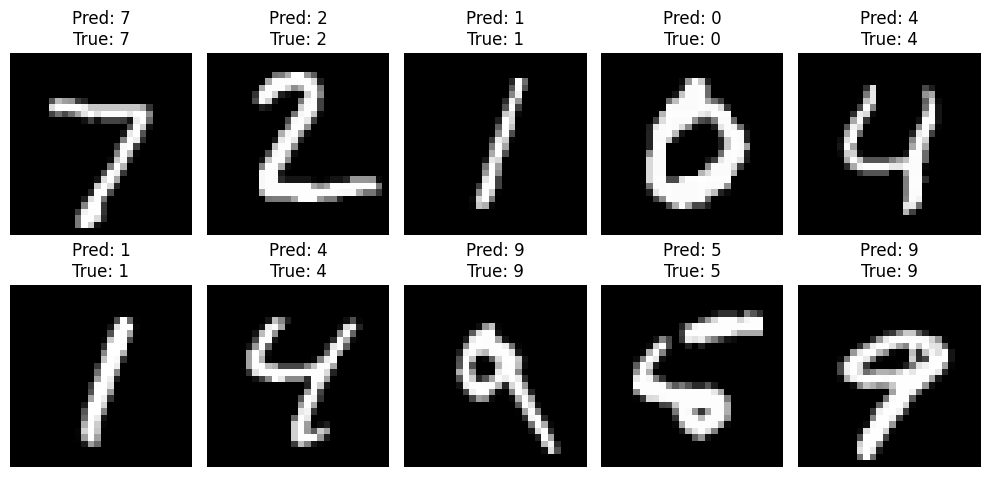

In [6]:
class RearrangeLayer(nn.Module):
    """A custom PyTorch module to apply the rearrange function."""
    def __init__(self, pattern: str, **axes_lengths):
        super().__init__()
        self.pattern = pattern
        self.axes_lengths = axes_lengths

    def forward(self, x):
        return rearrange(x, self.pattern, **self.axes_lengths)

# --- Build custom CNN ---
conv_net_new = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=5),       # (b, 1, 28, 28) -> (b, 10, 24, 24)
    nn.MaxPool2d(kernel_size=2),           # -> (b, 10, 12, 12)
    nn.ReLU(),
    nn.Conv2d(10, 20, kernel_size=5),      # -> (b, 20, 8, 8)
    nn.MaxPool2d(kernel_size=2),           # -> (b, 20, 4, 4)
    nn.ReLU(),
    nn.Dropout2d(),
    RearrangeLayer('b c h w -> b (c h w)'), # -> (b, 320) where 320 = 20 * 4 * 4
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)

# --- Load Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- Train ---
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# --- Test ---
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    return accuracy

# --- Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = conv_net_new.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

epochs = 5
start_time = time.time()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader)

end_time = time.time()
elapsed_time_with_our_custom_einops = end_time - start_time
print(f"Total training time: {elapsed_time_with_our_custom_einops:.2f} seconds")



# --- Visualization of Predictions ---
model.eval()
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True).cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()
for i in range(10):
    img = data[i].cpu().numpy().squeeze()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Pred: {pred[i].item()}\nTrue: {target[i].item()}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Standard CNNs

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

# Define the CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)    # (b, 1, 28, 28) -> (b, 10, 24, 24)
        self.pool1 = nn.MaxPool2d(kernel_size=2)       # -> (b, 10, 12, 12)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)   # -> (b, 20, 8, 8)
        self.pool2 = nn.MaxPool2d(kernel_size=2)       # -> (b, 20, 4, 4)
        self.dropout2d = nn.Dropout2d()                 # 2D dropout for conv layers
        self.fc1 = nn.Linear(20 * 4 * 4, 50)           # Flatten: (b, 320) -> (b, 50)
        self.dropout = nn.Dropout()                     # 1D dropout for fully connected layers
        self.fc2 = nn.Linear(50, 10)                    # -> (b, 10)

    def forward(self, x):
        x = torch.relu(self.pool1(self.conv1(x)))
        x = torch.relu(self.pool2(self.conv2(x)))
        x = self.dropout2d(x)
        x = x.view(-1, 20 * 4 * 4)  # Flatten: (b, 20, 4, 4) -> (b, 320)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

# Load Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Test
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    return accuracy

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

epochs = 5
start_time = time.time()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader)

end_time = time.time()
elapsed_time_with_standard_cnn = end_time - start_time
print(f"Total training time: {elapsed_time_with_standard_cnn:.2f} seconds")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376745
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.768367
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.478243
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.328524
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.276981
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.294432
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.391765
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.459261
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.210606
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.077187

Test set: Average loss: 0.0963, Accuracy: 9684/10000 (96.84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.515003
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.158167
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.493459
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.175007
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.353576
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.192276
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.544460
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.263792
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.09234

# Lets check performance when using official Einops library

In [8]:
# !pip install --upgrade einops

In [9]:
# from einops import rearrange as ra
# from einops import repeat
# import numpy as np
# import time

# print("Starting timing tests...")
# total_start_time = time.time()

# # Operation 1
# x = np.random.rand(4, 5, 8)
# start = time.time()
# ra(x, "h w c -> w h c")
# end = time.time()
# print(f"Call 1 (h w c -> w h c): {end - start:.6f} seconds")

# # Operation 2
# x = np.random.rand(4, 8, 2)
# start = time.time()
# ra(x, 'h w c -> (h w c)')
# end = time.time()
# print(f"Call 2 (h w c -> (h w c)): {end - start:.6f} seconds")

# # Operation 3
# x = np.random.rand(3, 4)
# start = time.time()
# ra(x, 'h w -> w h')
# end = time.time()
# print(f"Call 3 (h w -> w h): {end - start:.6f} seconds")

# # Operation 4
# x = np.random.rand(12, 5)
# start = time.time()
# ra(x, '(h w) c -> h w c', h=3, w=4)
# end = time.time()
# print(f"Call 4 ((h w) c -> h w c): {end - start:.6f} seconds")

# # Operation 5
# x = np.random.rand(3, 4, 5)
# start = time.time()
# ra(x, 'h w c -> (h w) c')
# end = time.time()
# print(f"Call 5 (h w c -> (h w) c): {end - start:.6f} seconds")

# # Operation 6
# x = np.random.rand(3, 1, 5)
# start = time.time()
# repeat(x, 'h 1 c -> h b c', b=4)
# end = time.time()
# print(f"Call 6 (h 1 c -> h b c): {end - start:.6f} seconds")

# # Operation 7
# x = np.random.rand(2, 3, 4, 5)
# start = time.time()
# ra(x, '... h w -> ... (h w)')
# end = time.time()
# print(f"Call 7 (... h w -> ... (h w)): {end - start:.6f} seconds")

# total_end_time = time.time()
# time_differenceofficialrepo = total_end_time - total_start_time
# print(f"Total time difference: {time_differenceofficialrepo:.6f} seconds")

## Use this to Test size limit until system crashes

In [11]:
# import numpy as np
# from einops import rearrange

# h, w, c = 1, 1, 1  # Start with this shape

# while True:
#     try:
#         print(f"Trying size: ({h}, {w}, {c})")
#         x = np.random.rand(h, w, c)  # Allocate memory
#         result = rearrange(x, 'h w c -> (h w c)')  # Rearrange tensor
#         h *= 2  # Increase h
#         w *= 2  # Increase w
#         c *= 2  # Increase c
#     except MemoryError:
#         print(f"MemoryError at size: ({h}, {w}, {c})")
#         break
#     except ValueError as e:
#         print(f"ValueError at size: ({h}, {w}, {c}), Error: {e}")
#         break

# print(f"Max feasible dimensions before failure: ({h//2}, {w//2}, {c//2})")
